In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import gmaps

# Google API Key
from api_keys import g_key

In [86]:
# determine the data source
lga_data = "Data/offences_per_lga.xlsx"
lat_long_data = "Data/SuburbsLatLong.csv"

# create data frame
offences_per_lga = pd.read_excel(lga_data)
lat_long_df = pd.read_csv(lat_long_data)
lat_long_df = lat_long_df.dropna()
offences_per_lga


,Year,Year ending,Police Region,Local Government Area,Offence Count,"Rate per 100,000 population"
0,2021,December,1 North West Metro,Banyule,7357,5597.317575
1,2021,December,1 North West Metro,Brimbank,17022,8391.791476
2,2021,December,1 North West Metro,Darebin,12655,7675.314856
3,2021,December,1 North West Metro,Hobsons Bay,5832,5990.557024
4,2021,December,1 North West Metro,Hume,17893,7286.510889
...,...,...,...,...,...,...
865,2012,December,4 Western,Total,65046,7118.982421
866,2012,December,Justice Institutions and Immigration Facilities,Justice Institutions and Immigration Facilities,1043,NaN
867,2012,December,Justice Institutions and Immigration Facilities,Total,1043,NaN
868,2012,December,Unincorporated Vic,Unincorporated Vic,126,NaN


In [87]:
# remove from dataframe the Police Region: Justice Institutions and Immigration Facilities
offences_per_lga = offences_per_lga.loc[
    (offences_per_lga["Police Region"] != "Justice Institutions and Immigration Facilities") & 
    (offences_per_lga["Police Region"] != "Unincorporated Vic"),:]

# recut the dataframe to sum the offence count
offences_year_police_df = offences_per_lga[["Year","Police Region","Offence Count"]]

# group the data by year by police region
sum_offences_year_police_df = offences_year_police_df.groupby(["Year","Police Region"]).sum()["Offence Count"].unstack()
sum_offences_year_police_df

Police Region,1 North West Metro,2 Eastern,3 Southern Metro,4 Western
Year,,,,
2012,339674,180646,193244,130092
2013,342878,189174,203178,136624
2014,358482,201184,210150,145378
2015,385932,218104,236550,156604
2016,418356,243526,261128,175236
2017,379516,225120,230076,166666
2018,389840,225320,234212,167538
2019,401840,246008,246288,171758
2020,414118,250858,253270,171404


Number of offences by police region, 2012 to 2021

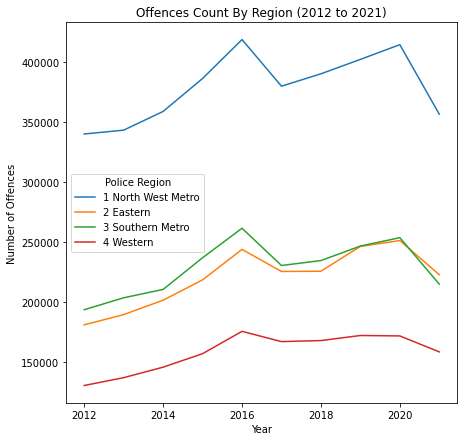

In [121]:
fig_offences_by_region = sum_offences_year_police_df.plot(
    kind="line",figsize=(7,7),
    title="Offences Count By Region (2012 to 2021)",
    xlabel="Year",
    ylabel="Number of Offences")

# fig_offences_by_region.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("output/offences_by_police_region.png")

In [105]:
top_bottom_n = 4

# recut the dataframe
region_df = offences_per_lga[["Year","Police Region","Local Government Area","Offence Count"]]

top_bottom_lga = region_df.loc[region_df["Local Government Area"] != "Total",:]
top_bottom_lga = top_bottom_lga.groupby(["Local Government Area"]).sum()
top_bottom_lga = top_bottom_lga.sort_values(["Offence Count"],ascending=False)
top_bottom_lga = top_bottom_lga.drop(["Year"],1)

# retrieve n numbers top bottom LGA
top_bottom_lga = pd.concat([top_bottom_lga.head(top_bottom_n),top_bottom_lga.tail(top_bottom_n)])
top_bottom_lga = top_bottom_lga.drop(["Offence Count"],1)

# merge dataframe to retrieve the yearly offence count
top_bottom_lga = pd.merge(top_bottom_lga,region_df,on="Local Government Area",how="inner")

C:\Users\chris\AppData\Local\Temp/ipykernel_19556/1297712403.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  top_bottom_lga = top_bottom_lga.drop(["Year"],1)
C:\Users\chris\AppData\Local\Temp/ipykernel_19556/1297712403.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  top_bottom_lga = top_bottom_lga.drop(["Offence Count"],1)


Which police regions are the top bottom LGA located?

In [103]:
group_top_bottom_region = top_bottom_lga.groupby(["Police Region","Local Government Area"]).sum()
group_top_bottom_region = group_top_bottom_region.drop(["Year"],1)
group_top_bottom_region

C:\Users\chris\AppData\Local\Temp/ipykernel_19556/1361718761.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  group_top_bottom_region = group_top_bottom_region.drop(["Year"],1)


Offence Count
Police Region      Local Government Area               
1 North West Metro  Hume                         194790
                    Melbourne                    351548
2 Eastern           Towong                         2264
3 Southern Metro    Casey                        200579
4 Western           Buloke                         2716
                    Greater Geelong              203355
                    Queenscliffe                   1409
                    West Wimmera                   1758

What are the trends for each top & bottom LGA?

In [104]:
# group by LGA
top_bottom_lga = top_bottom_lga.drop(["Police Region"],1)
group_top_bottom_lga = top_bottom_lga.groupby(["Year","Local Government Area"]).sum()["Offence Count"].unstack()


C:\Users\chris\AppData\Local\Temp/ipykernel_19556/3634007690.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  top_bottom_lga = top_bottom_lga.drop(["Police Region"],1)


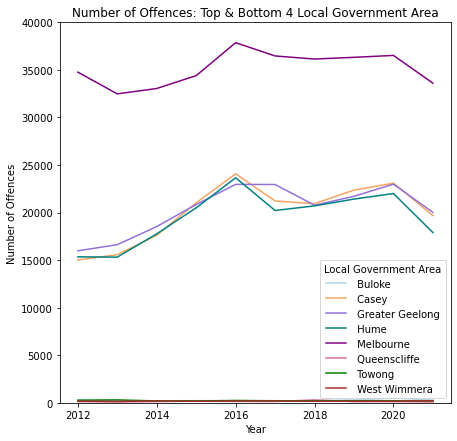

In [120]:
# line plotting
colours = ["lightblue","sandybrown","mediumpurple", "teal", "purple","palevioletred","green","brown"]

top_bottom_fig = group_top_bottom_lga.plot(
    kind = "line",
    title = f'Number of Offences: Top & Bottom {top_bottom_n} Local Government Area',
    xlabel = "Year",
    ylabel = "Number of Offences",
    color = colours,
    figsize = (7,7))

plt.ylim(0,40000)
# top_bottom_fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("output/top_bottom_LGA.png")

Where have the offences been concentrated in Victoria?

In [113]:
# create heat map region df
heatmap_region_df = offences_per_lga[["Local Government Area","Offence Count"]]

# remove the total line
heatmap_region_df.loc[heatmap_region_df["Offence Count"] != "Total",:]

# create lat long columns
heatmap_region_df["lat"]=""
heatmap_region_df["long"]=""

# create parameter dict
parameter = {"key":g_key}

#loop through each local government area to retrieve lat long values
for index,row in heatmap_region_df.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"

    city = row["Local Government Area"]
    state = "victoria"
    country = "australia"

    # update parameter
    parameter["address"]=f"{city},{state},{country}"

    # make request
    lga_lat_long = requests.get(base_url,params=parameter)

    # convert to json
    lga_lat_long = lga_lat_long.json()

    # update the data frame
    heatmap_region_df.loc[index,"lat"] = lga_lat_long["results"][0]["geometry"]["location"]["lat"]    
    heatmap_region_df.loc[index,"long"] = lga_lat_long["results"][0]["geometry"]["location"]["lng"]

C:\Users\chris\AppData\Local\Temp/ipykernel_19556/1535761406.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_region_df["lat"]=""
C:\Users\chris\AppData\Local\Temp/ipykernel_19556/1535761406.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_region_df["long"]=""
C:\Users\chris\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [114]:
# group by local government area
group_heatmap_region = heatmap_region_df.groupby(["Local Government Area","lat","long"],as_index=False).agg({"Offence Count":sum})
# group_heatmap_region_df = heatmap_region_df.groupby(["Local Government Area","lat","long"])

group_heatmap_region_df = pd.DataFrame(group_heatmap_region)


In [117]:
# Configure API key for Gmap
gmaps.configure(api_key=g_key)

# Determine LGA location based on Lat and Long
lga_locations = group_heatmap_region_df[["lat","long"]]

# Determine offence count value
offence_count = group_heatmap_region_df["Offence Count"].astype(float)

# Create humidity heatmap layer
fig_offence_lga = gmaps.figure()
lga_offence_layer = gmaps.heatmap_layer(lga_locations,weights = offence_count, dissipating=False, max_intensity=5000, point_radius=0.1)
fig_offence_lga.add_layer(lga_offence_layer)
fig_offence_lga


Figure(layout=FigureLayout(height='420px'))